# Execute the trained model (WSI level)

In [2]:
import os
import sys

current_path = os.path.abspath('.')
root_path = os.path.dirname(os.path.dirname(current_path))
sys.path.append(root_path)

from sourcecode.unet_model import *
from sourcecode.wsi_image_utils import *

import os
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils
from torch.autograd import Variable

import gc 

torch.cuda.empty_cache()
gc.collect()


dataset_dir = "../../datasets/CANINE"
model_dir = "../../models"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)

use_cuda=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"

# loads our trained fcn model
trained_model_version = "OCDC__Size-640x640_Color-LAB_Epoch-500_Images-840_Batch-1"
trained_model_path="{}/{}".format(model_dir, '{}.pth'.format(trained_model_version))

if not os.path.isfile(trained_model_path):
    
    logger.info("Trained model not found: '{}'.".format(trained_model_path))
    
else:
    
    model = load_checkpoint(file_path=trained_model_path, img_input_size=patch_size, use_cuda=use_cuda)

    dataset_type = "testing"
    classes = ["tumor"]
    for cls in classes:

        wsi_images_dir = "{}/{}/{}/wsi".format(dataset_dir, dataset_type, cls)
        patch_images_results_dir = "{}/results/{}/{}/{}/patch/640x640".format(dataset_dir, trained_model_version, dataset_type, cls)
        wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(dataset_dir, trained_model_version, dataset_type, cls)
        
        print("WSI images dir: {}".format(wsi_images_dir))
        for r, d, f in sorted(os.walk(wsi_images_dir)):
            for wsi_file in sorted(f):

                wsi_image_file = "{}/{}".format(r, wsi_file)
                wsi_image_number = wsi_file.replace(".svs", "")

                file_is_svs = wsi_image_file.lower().endswith('.svs')
                if file_is_svs:

                    logger.info("Processing wsi '{}'".format(wsi_file))
                    if not os.path.isfile(wsi_image_file):
                        logger.info("WSI image not found: '{}'.".format(wsi_file))
                        break
                    
                    # check directory to save image-patches
                    dir_to_save = "{}/{}".format(patch_images_results_dir, wsi_image_number)
                    if not os.path.exists(dir_to_save):
                        os.makedirs("{}/{}".format(wsi_images_results_dir, wsi_image_number))
                        os.makedirs("{}/01-unet_result".format(dir_to_save))
                        
                    # scale down image
                    wsi_image = open_wsi(wsi_image_file)
                    pil_scaled_down_image = scale_down_wsi(wsi_image, magnification, False)
                    np_scaled_down_image = pil_to_np(pil_scaled_down_image)

                    # extract tissue region 
                    np_tissue_mask, np_masked_image = extract_normal_region_from_wsi(wsi_image_file, np_scaled_down_image, None)
                    pil_masked_image = np_to_pil(np_masked_image)

                    # draw the heat grid
                    pil_img_result, heat_grid, number_of_tiles = draw_heat_grid(np_masked_image, tile_size)

                    # save scaled down wsi
                    utils.save_image(TF.to_tensor(pil_scaled_down_image), '{}/{}/{}.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                    utils.save_image(TF.to_tensor(pil_masked_image), '{}/{}/{}__tissue.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                    utils.save_image(TF.to_tensor(pil_img_result), '{}/{}/{}__tissuegrid.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                    
                    # run the model
                    count_tiles = 0
                    count_roi_tiles = 0
                    for idx, (position, row, column, location, size, color) in enumerate(heat_grid):

                        if color != GREEN_COLOR and idx > 1700:

                            count_tiles += 1

                            r_s = row * tile_size
                            r_e = r_s + tile_size
                            c_s = column * tile_size
                            c_e = c_s + tile_size
                            np_tile_masked = np_masked_image[r_s:r_e, c_s:c_e]
                            print('{} - {}_r{}c{}.png'.format(idx, wsi_image_number, row, column))

                            # only tile with valid size
                            if np_tile_masked.shape[0] == tile_size and np_tile_masked.shape[1] == tile_size:

                                # read the tile from the original wsi image
                                pil_input_tile, np_input_tile = read_region(wsi_image_file, column, row, magnification, tile_size)

                                # run the model
                                if color_model == "LAB":
                                    np_input_tile = rgb_to_lab(np_input_tile)

                                X = torch.from_numpy(np_input_tile).permute(2, 0, 1).float()
                                X = Variable(X.unsqueeze(0)).to(device) if use_cuda else X.unsqueeze(0)
                                y_hat = model(X).detach().cpu().squeeze(0)
                                #y_hat = model(X).squeeze(0)
                                output_tile = y_hat[0]
                                np_output_tile = output_tile.squeeze(0).detach().cpu().numpy()
                                #

                                # only tiles that something was found by model
                                if np.any(np.unique(np_output_tile >= 0.1)):

                                    # save the output image-patch results
                                    utils.save_image(output_tile, '{}/01-unet_result/{}_r{}c{}.png'.format(dir_to_save, wsi_image_number, row, column))

                                    np_output_tile[np_output_tile > 0] = 1
                                    count_roi_tiles += 1

                    logger.info("\t '{}/{}/{}' tiles identified as ROI by model".format(count_roi_tiles, count_tiles, len(heat_grid)))
                    logger.info("-")

                    # save scaled down wsi
                    utils.save_image(TF.to_tensor(pil_scaled_down_image), '{}/{}/{}.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                        

2021-12-06 14:58:24,456 :: INFO load_checkpoint :: 	 Model loaded on: cuda / 3 / 1 / (640, 640) / 31734913 params -> ../../models/OCDC__Size-640x640_Color-LAB_Epoch-500_Images-840_Batch-1.pth
2021-12-06 14:58:24,458 :: INFO <module> :: Processing wsi 'canine_image.svs'


WSI images dir: ../../datasets/CANINE/testing/tumor/wsi


2021-12-06 14:58:25,378 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'canine_image.svs'


1701 - canine_image_r9c54.png
1702 - canine_image_r9c55.png
1703 - canine_image_r9c56.png
1704 - canine_image_r9c57.png
1705 - canine_image_r9c58.png
1706 - canine_image_r9c59.png
1707 - canine_image_r9c60.png
1715 - canine_image_r9c68.png
1716 - canine_image_r9c69.png
1717 - canine_image_r9c70.png
1718 - canine_image_r9c71.png
1719 - canine_image_r9c72.png
1720 - canine_image_r9c73.png
1721 - canine_image_r9c74.png
1722 - canine_image_r9c75.png
1723 - canine_image_r9c76.png
1724 - canine_image_r9c77.png
1725 - canine_image_r9c78.png
1726 - canine_image_r9c79.png
1727 - canine_image_r9c80.png
1728 - canine_image_r9c81.png
1729 - canine_image_r9c82.png
1733 - canine_image_r9c86.png
1734 - canine_image_r9c87.png
1739 - canine_image_r9c92.png
1740 - canine_image_r9c93.png
1744 - canine_image_r9c97.png
1745 - canine_image_r9c98.png
1746 - canine_image_r9c99.png
1883 - canine_image_r10c53.png
1884 - canine_image_r10c54.png
1885 - canine_image_r10c55.png
1886 - canine_image_r10c56.png
1887 -

2021-12-06 16:38:06,762 :: INFO <module> :: 	 '6713/11417/24522' tiles identified as ROI by model
2021-12-06 16:38:06,763 :: INFO <module> :: -


24458 - canine_image_r133c119.png
24459 - canine_image_r133c120.png


# Generate the heatmaps (WSI level)

2021-12-06 16:42:02,333 :: INFO <module> :: Segmenting wsi image: 'canine_image.svs'


WSI images dir: ../../datasets/CANINE/testing/tumor/wsi


2021-12-06 16:43:38,268 :: INFO <module> :: 	 '5046' tiles identified as ROI after post processing
2021-12-06 16:43:38,269 :: INFO <module> :: -


WSI images dir: ../../datasets/CANINE/testing/normal/wsi


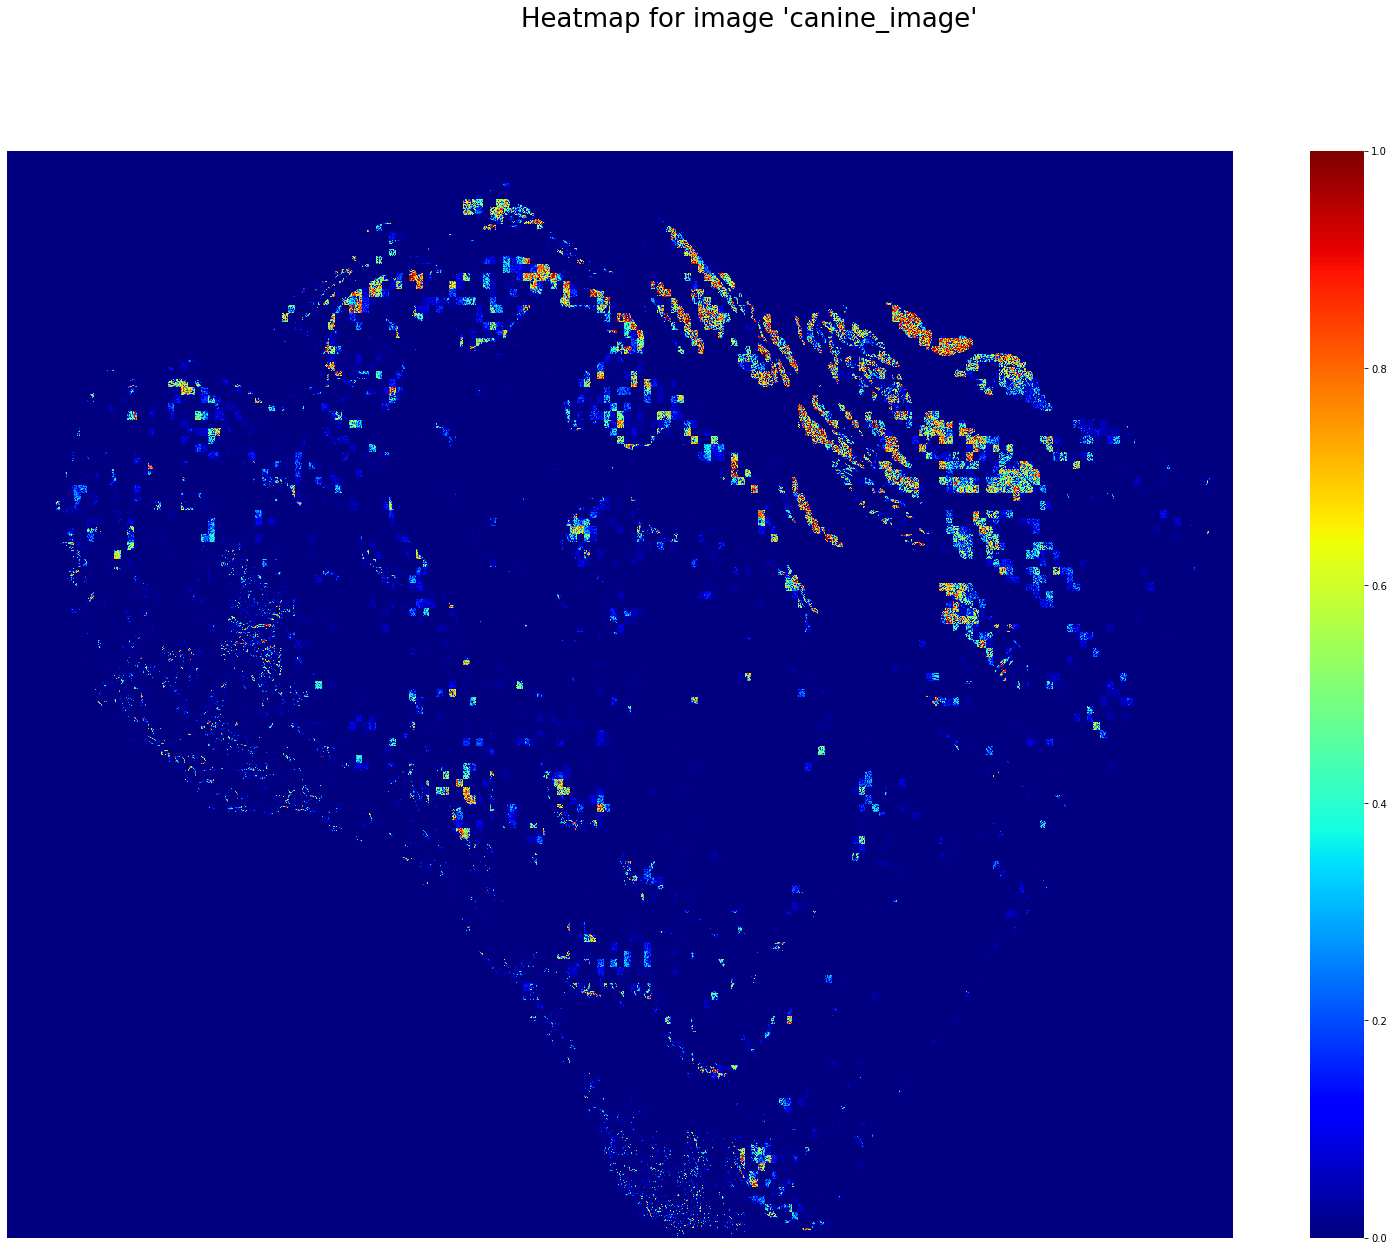

In [3]:
import os
import sys

current_path = os.path.abspath('.')
root_path = os.path.dirname(os.path.dirname(current_path))
sys.path.append(root_path)

from sourcecode.wsi_image_utils import *

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import *
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils


dataset_dir = "../../datasets/CANINE"
model_dir = "../../models"
trained_model_version = "OCDC__Size-640x640_Color-LAB_Epoch-500_Images-840_Batch-1"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)


dataset_type = "testing"
classes = ["tumor", "normal"]
for cls in classes:

    wsi_images_dir = "{}/{}/{}/wsi".format(dataset_dir, dataset_type, cls)
    patch_images_results_dir = "{}/results/{}/{}/{}/patch/640x640".format(dataset_dir, trained_model_version, dataset_type, cls)
    wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(dataset_dir, trained_model_version, dataset_type, cls)
    
    print("WSI images dir: {}".format(wsi_images_dir))
    for r, d, f in sorted(os.walk(wsi_images_dir)):
        for wsi_file in sorted(f):

            wsi_image_file = "{}/{}".format(r, wsi_file)
            wsi_image_number = wsi_file.replace(".svs", "")
            
            file_is_tif = wsi_image_file.lower().endswith('.svs')
            if file_is_tif:

                logger.info("Segmenting wsi image: '{}'".format(wsi_file))
                unet_results_dir = "{}/{}/01-unet_result".format(patch_images_results_dir, wsi_image_number)
                if not os.path.exists(unet_results_dir):
                    logger.info("\t This WSI image was not processed by our fcn based method yet.")
                    logger.info("\t {}".format(unet_results_dir))
                    continue
                
                original_img_path = "{}/{}/{}.png".format(wsi_images_results_dir, wsi_image_number, wsi_image_number)
                pil_original_image = load_pil_image(original_img_path, gray=False)
                np_scaled_down_image = pil_to_np(pil_original_image)

                # fcn roi identification
                count_tiles = 0
                np_heatmap = np.zeros((np_scaled_down_image.shape[0], np_scaled_down_image.shape[1]))
                np_tissue_roi = np.zeros_like(np_scaled_down_image)
                for _, _, unet_tile_files in sorted(os.walk(unet_results_dir)):
                    for unet_tile_image_file in sorted(unet_tile_files):
                        if os.path.isfile("{}/{}".format(unet_results_dir, unet_tile_image_file)):

                            # load the unet image-patch result
                            np_tile_unet = np.copy(pil_to_np(load_pil_image("{}/{}".format(unet_results_dir, unet_tile_image_file), gray=True)))
                            np_tile_unet = np_tile_unet * (1.0/255)
                            np_tile_unet[np.isnan(np_tile_unet)] = 0

                            # check if exists values greather than 0.x
                            if np.any(np.unique(np_tile_unet > 0.1)):

                                aux_row_column = unet_tile_image_file.split("_")[-1].replace(".png", "").split('c')
                                row = int(aux_row_column[0].replace("r", ""))
                                column = int(aux_row_column[-1])

                                r_s = row * tile_size
                                r_e = r_s + tile_size
                                c_s = column * tile_size
                                c_e = c_s + tile_size
                                np_heatmap[r_s:r_e, c_s:c_e] = image_resize(np_tile_unet, height=tile_size)

                                np_tile_unet = basic_threshold(np_tile_unet, threshold=0.01, output_type="uint8")
                                tissue_area = tissue_percent(np_tile_unet)
                                if tissue_area > 1:

                                    count_tiles += 1

                                else:
                                    np_heatmap[r_s:r_e, c_s:c_e] = 0

                logger.info("\t '{}' tiles identified as ROI after post processing".format(count_tiles))
                logger.info("-")
                
                f = plt.figure(figsize=((np_heatmap.shape[1]*20)/np_heatmap.shape[0], 20))
                f.suptitle("Heatmap for image '{}'".format(wsi_image_number), fontsize=26)

                ax1 = f.add_subplot(111)
                sns.heatmap(np_heatmap, ax=ax1, xticklabels=False, yticklabels=False, vmin=0, vmax=1, cmap="jet", cbar=True, robust=True)

                f.savefig(original_img_path.replace("{}.png".format(wsi_image_number), "{}_heatmap.png".format(wsi_image_number)))
                utils.save_image(TF.to_tensor(np_to_pil(np_heatmap)), original_img_path.replace("{}.png".format(wsi_image_number), "{}_heatmap_gray.png".format(wsi_image_number)))

# Generate the lesion localization points (WSI level)

In [4]:
import os
import sys

current_path = os.path.abspath('.')
root_path = os.path.dirname(os.path.dirname(current_path))
sys.path.append(root_path)

from sourcecode.wsi_image_utils import *

import csv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import *
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils

from scipy import ndimage as nd
from skimage import measure

dataset_dir = "../../datasets/CANINE"
model_dir = "../../models"
trained_model_version = "OCDC__Size-640x640_Color-LAB_Epoch-500_Images-840_Batch-1"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)

threshold_prob = 0.5
threshold_itc = 200/(0.243 * pow(2, 5))

dataset_type = "testing"
classes = ["tumor", "normal"]
for cls in classes:

    wsi_images_dir = "{}/{}/{}/wsi".format(dataset_dir, dataset_type, cls)
    wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(dataset_dir, trained_model_version, dataset_type, cls)

    print("WSI images dir: {}".format(wsi_images_dir))
    for r, d, f in sorted(os.walk(wsi_images_dir)):
        for wsi_file in sorted(f):

            wsi_image_file = "{}/{}".format(r, wsi_file)
            wsi_image_number = wsi_file.replace(".svs", "")

            file_is_tif = wsi_image_file.lower().endswith('.svs')
            if file_is_tif:
                
                logger.info("Generating the lesion localization points for wsi image: '{}'".format(wsi_file))
                
                heatmap_gray_path = "{}/{}/{}_heatmap_gray.png".format(wsi_images_results_dir, wsi_image_number, wsi_image_number)
                if not os.path.exists(heatmap_gray_path):
                    logger.info("\t This original WSI image was not processed yet.")
                    logger.info("\t {}".format(heatmap_gray_path))
                    continue
                                
                np_heatmap_gray = load_np_image(heatmap_gray_path, color_model="GRAY") * (1.0/255)
                np_heatmap_points = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))
                np_heatmap_convex = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))

                seg_threshold_img = basic_threshold(np_heatmap_gray, threshold=threshold_prob, output_type="uint8")
                seg_threshold_img = nd.morphology.binary_fill_holes(seg_threshold_img)
                
                seg_threshold_img_labels = measure.label(seg_threshold_img, connectivity=2)
                seg_threshold_img = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))
                
                properties = measure.regionprops(seg_threshold_img_labels)
                
                csv_file_path = heatmap_gray_path.replace("_heatmap_gray.png", ".csv")
                with open(csv_file_path, mode='w') as result_file:

                    result_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                                        
                    labels = np.unique(seg_threshold_img_labels)
                    for lbl in range(1, (np.max(labels)+1)):
                        
                        centroid = (int(properties[lbl-1].centroid[0]), int(properties[lbl-1].centroid[1]))
                        major_axis_length = properties[lbl-1].major_axis_length
                        
                        if major_axis_length > threshold_itc:

                            hull = properties[lbl-1].convex_image
                            bbox = properties[lbl-1].bbox
                            #mean_intensity = np.mean(np_heatmap_gray[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True])
                            #centroid_intensity = np_heatmap_gray[centroid[0], centroid[1]]
                            max_intensity = np.max(np_heatmap_gray[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True])
                                                        
                            prob = max_intensity
                            if prob > 0.0:
                                
                                #print("   {:04.2f}, {}, {}".format(prob, centroid[1], centroid[0]))
                                seg_threshold_img[seg_threshold_img_labels == lbl] = 1
                                
                                result_writer.writerow(["{:04.2f}".format(prob), centroid[1], centroid[0]])
                                np_heatmap_points[centroid[0]-10:centroid[0]+10, centroid[1]-10:centroid[1]+10] = 1
                                np_heatmap_convex[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True] = 1
                                np_heatmap_convex[centroid[0]-10:centroid[0]+10, centroid[1]-10:centroid[1]+10] = 0.5
                        
                utils.save_image(TF.to_tensor(np_to_pil(seg_threshold_img)), heatmap_gray_path.replace("_gray", "_gray_threshold_{}".format(threshold_prob)))
                utils.save_image(TF.to_tensor(np_to_pil(np_heatmap_points)), heatmap_gray_path.replace("_gray", "_points"))
                #utils.save_image(TF.to_tensor(np_to_pil(np_heatmap_convex)), heatmap_gray_path.replace("_gray", "_gray_threshold_{}_convex".format(threshold_prob)))


2021-12-06 16:46:40,365 :: INFO <module> :: Generating the lesion localization points for wsi image: 'canine_image.svs'


WSI images dir: ../../datasets/CANINE/testing/tumor/wsi
WSI images dir: ../../datasets/CANINE/testing/normal/wsi


# Execute the trained model (image-patch level)

In [2]:
import os
import sys

current_path = os.path.abspath('.')
root_path = os.path.dirname(os.path.dirname(current_path))
sys.path.append(root_path)

from sourcecode.unet_model import *
from sourcecode.wsi_image_utils import *

import os
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils
from torch.autograd import Variable

import gc 

torch.cuda.empty_cache()
gc.collect()


dataset_dir = "../../datasets/CANINE"
model_dir = "../../models"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)
threshold_prob = 0.50
threshold_itc = 200/(0.243 * pow(2, 5))

use_cuda=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"

# loads our trained fcn model
trained_model_version = "OCDC__Size-640x640_Color-LAB_Epoch-500_Images-840_Batch-1"
trained_model_path="{}/{}".format(model_dir, '{}.pth'.format(trained_model_version))

if not os.path.isfile(trained_model_path):
    
    logger.info("Trained model not found: '{}'.".format(trained_model_path))
    
else:
    
    model = load_checkpoint(file_path=trained_model_path, img_input_size=patch_size, use_cuda=use_cuda)

    dataset_type = "testing"
    classes = ["tumor"]
    for cls in classes:

        wsi_images_dir = "{}/{}/{}/wsi".format(dataset_dir, dataset_type, cls)
        patch_images_results_dir = "{}/results/{}/{}/{}/patch/640x640".format(dataset_dir, trained_model_version, dataset_type, cls)
        wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(dataset_dir, trained_model_version, dataset_type, cls)
        
        print("WSI images dir: {}".format(wsi_images_dir))
        for r, d, f in sorted(os.walk(wsi_images_dir)):
            for wsi_file in sorted(f):

                wsi_image_file = "{}/{}".format(r, wsi_file)
                wsi_image_number = wsi_file.replace(".svs", "")

                file_is_svs = wsi_image_file.lower().endswith('.svs')
                if file_is_svs:

                    logger.info("Processing wsi '{}'".format(wsi_file))
                    if not os.path.isfile(wsi_image_file):
                        logger.info("WSI image not found: '{}'.".format(wsi_file))
                        break
                    
                    # check directory to save image-patches
                    dir_to_save = "{}/{}".format(patch_images_results_dir, wsi_image_number)
                    if not os.path.exists("{}/00-original".format(dir_to_save)):
                        os.makedirs("{}/00-original".format(dir_to_save))
                        os.makedirs("{}/02-unet_result_mask".format(dir_to_save))
                        os.makedirs("{}/03-roi".format(dir_to_save))
                        
                    # scale down image
                    wsi_image = open_wsi(wsi_image_file)
                    pil_scaled_down_image = scale_down_wsi(wsi_image, magnification, False)
                    np_scaled_down_image = pil_to_np(pil_scaled_down_image)

                    # extract tissue region 
                    np_tissue_mask, np_masked_image = extract_normal_region_from_wsi(wsi_image_file, np_scaled_down_image, None)
                    pil_masked_image = np_to_pil(np_masked_image)

                    # draw the heat grid
                    pil_img_result, heat_grid, number_of_tiles = draw_heat_grid(np_masked_image, tile_size)

                    count_image_patches = 0
                    for idx, (position, row, column, location, size, color) in enumerate(heat_grid):

                        unet_result_patch_img = '{}/01-unet_result/{}_r{}c{}.png'.format(dir_to_save, wsi_image_number, row, column)
                        if color != GREEN_COLOR and os.path.exists(unet_result_patch_img):

                            r_s = row * tile_size
                            r_e = r_s + tile_size
                            c_s = column * tile_size
                            c_e = c_s + tile_size
                            np_tile_masked = np_masked_image[r_s:r_e, c_s:c_e]

                            tile_pil, tile_np = read_region(wsi_image_file, column, row, magnification, tile_size)
                            left = (column * tile_size_original)
                            top = (row * tile_size_original)

                            # save the original image-patch
                            tile_pil.save('{}/00-original/{}_r{}c{}.png'.format(dir_to_save, wsi_image_number, row, column))

                            # save the predicted tumor mask
                            predicted_pil_img = load_pil_image(unet_result_patch_img, gray=True)
                            predicted_np_img = np.copy(pil_to_np(predicted_pil_img))
                            predicted_np_img = predicted_np_img * (1.0/255)
                            predicted_np_img = basic_threshold(predicted_np_img, threshold=threshold_prob, output_type="uint8")

                            predicted_labels = measure.label(predicted_np_img, connectivity=2)
                            predicted_np_img = np.zeros((predicted_np_img.shape[0], predicted_np_img.shape[1]))
                            labels = np.unique(predicted_labels)
                            properties = measure.regionprops(predicted_labels)
                            for lbl in range(1, np.max(labels)):
                                major_axis_length = properties[lbl-1].major_axis_length
                                if major_axis_length > threshold_itc:
                                    predicted_np_img[predicted_labels == lbl] = 1

                            # only image-patches that tumor regions was predicted by model
                            if np.any(np.unique(predicted_np_img > 0.1)):

                                np_to_pil(predicted_np_img).save('{}/02-unet_result_mask/{}_r{}c{}.png'.format(dir_to_save, wsi_image_number, row, column))
                                
                                # save the predicted tumor mask over the original image-patch
                                roi_image = blend_image(np_to_pil(tile_np), np_to_pil(predicted_np_img), foreground='red', alpha=0.6, inverse=True)
                                utils.save_image(TF.to_tensor(roi_image), '{}/03-roi/{}_r{}c{}.png'.format(dir_to_save, wsi_image_number, row, column))

2021-12-05 17:46:38,990 :: INFO load_checkpoint :: 	 Model loaded on: cpu / 3 / 1 / (640, 640) / 31734913 params -> ../../models/OCDC__Size-640x640_Color-LAB_Epoch-500_Images-840_Batch-1.pth
2021-12-05 17:46:39,018 :: INFO <module> :: Processing wsi 'canine_image.svs'
2021-12-05 17:46:41,901 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'canine_image.svs'
